In [0]:
import pandas as pd
from string import ascii_letters
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

uri = "https://raw.githubusercontent.com/BiaChacon/data-science-starting/master/datasets/microdados_enem/MICRODADOS_ENEM_2018_SAMPLE_43278.csv"
dados = pd.read_csv(uri)

## Desafio 1
Se a pessoa não teve presença, preencha a nota dela com algum número. A nota 0? A nota média? A mediana?

In [0]:
colunas_de_notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
dados_notas = dados[colunas_de_notas]

notas_null = dados_notas.query("NU_NOTA_CN.isna() and NU_NOTA_LC.isna() \
and NU_NOTA_CH.isna() and NU_NOTA_MT.isna()", engine="python")
data = dados_notas.drop(notas_null.index)

data.columns = ['ciencias_naturais', 'ciencias_humanas', 'linguagem_codigo', 'matematica', 'redacao']
data.fillna(0, inplace=True)

## Desafio 2
A matriz de correlação está feiosa, vamos deixar mais bonita? :) Não se esqueça de manter os valores dentro delas.

,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
ciencias_naturais,1.00,0.36,0.36,0.86,0.38
ciencias_humanas,0.36,1.00,0.73,0.38,0.51
linguagem_codigo,0.36,0.73,1.00,0.39,0.57
matematica,0.86,0.38,0.39,1.00,0.40
redacao,0.38,0.51,0.57,0.40,1.00


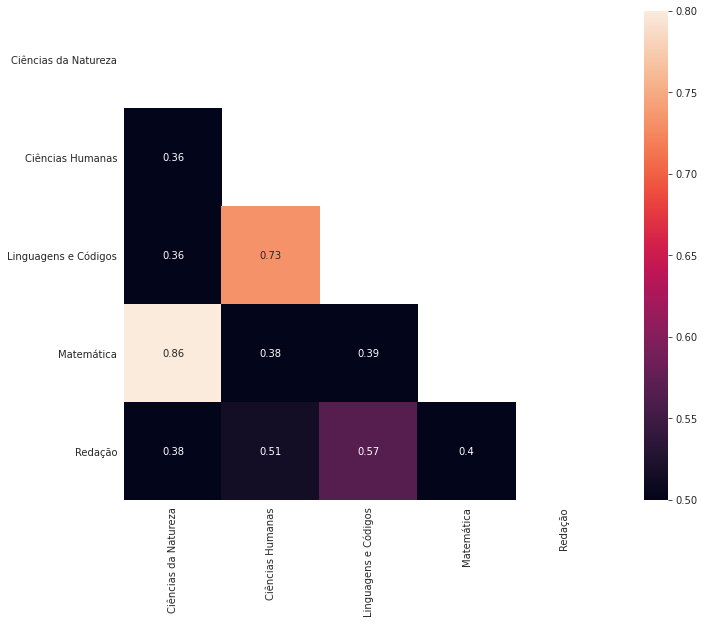

In [15]:
corr = data.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
labels = ['Ciências da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação']
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(11, 9))
    ax = sns.heatmap(corr, mask=mask, vmin=0.5, vmax=0.8, 
    annot=True, square=True, xticklabels=labels, yticklabels=labels)
corr

## Desafio 3
Pairplot dos acertos de cada categoria (CN, CH, MT, LC, nota pura da redação). Usar o gabarito e as respostas

In [0]:
def conta_acertos(dado, resps, gabarito):
  cont = [sum(1 for i, j in zip(g, h) if i == j) for g, h in zip(dado[resps], dado[gabarito])]
  return cont

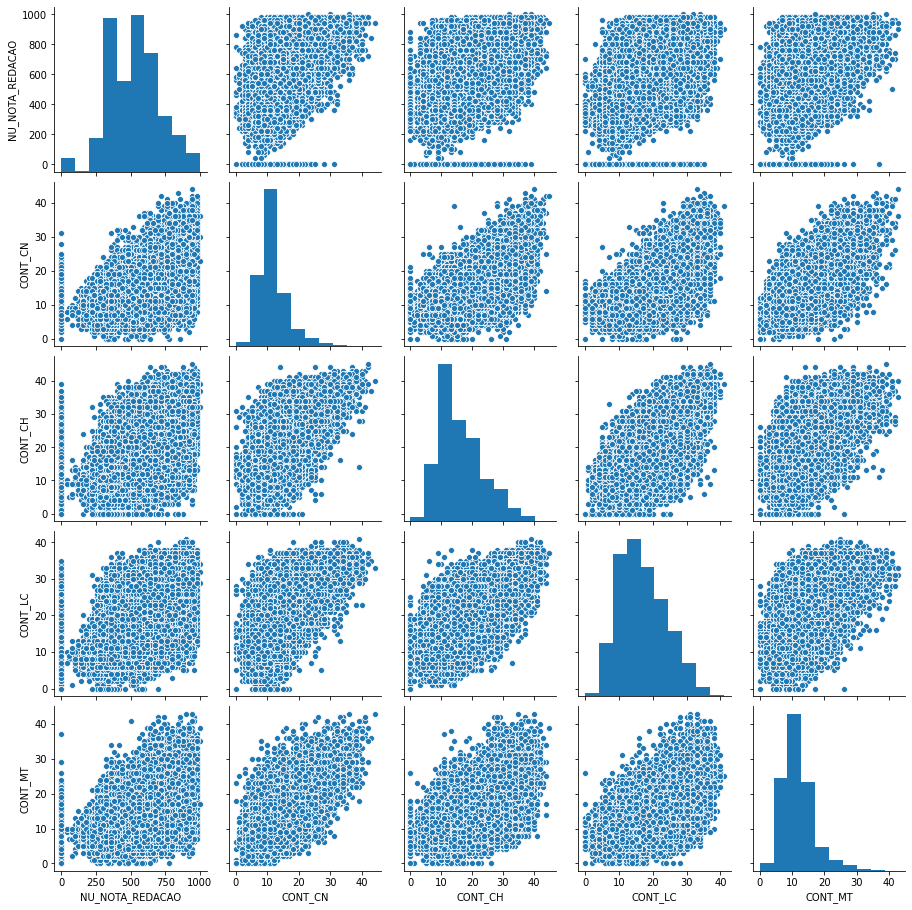

In [19]:
colunas_respostas = ['TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 
                      'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 
                      'TX_GABARITO_LC', 'TX_GABARITO_MT', 'NU_NOTA_REDACAO']
dados_respostas = dados[colunas_respostas].dropna()                

dados_respostas["CONT_CN"] = conta_acertos(dados_respostas, "TX_RESPOSTAS_CN", "TX_GABARITO_CN")
dados_respostas["CONT_CH"] = conta_acertos(dados_respostas, "TX_RESPOSTAS_CH", "TX_GABARITO_CH")
dados_respostas["CONT_LC"] = conta_acertos(dados_respostas, "TX_RESPOSTAS_LC", "TX_GABARITO_LC")
dados_respostas["CONT_MT"] = conta_acertos(dados_respostas, "TX_RESPOSTAS_MT", "TX_GABARITO_MT")

dados_respostas.drop(columns=['TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT',
                              'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT'])
sns.pairplot(dados_respostas)

dados_sem_zero = data.query("ciencias_naturais > 0 and ciencias_humanas > 0  \
                             and linguagem_codigo > 0 and matematica > 0 \
                             and redacao > 0")

## Desafio 4
Remover todos os zeros. Tomar o cuidado que no desafio 1 já tomamos decisões ligadas a limpeza dos dados também. Você também pode exportar para outro CSV se quiser.

,ciencias_naturais,ciencias_humanas,linguagem_codigo,matematica,redacao
1,523.10,671.30,661.60,738.00,680.00
2,409.20,531.70,389.00,438.10,600.00
3,452.30,505.50,448.50,544.90,400.00
6,428.50,505.20,521.00,436.80,560.00
8,491.80,575.70,524.40,487.60,660.00


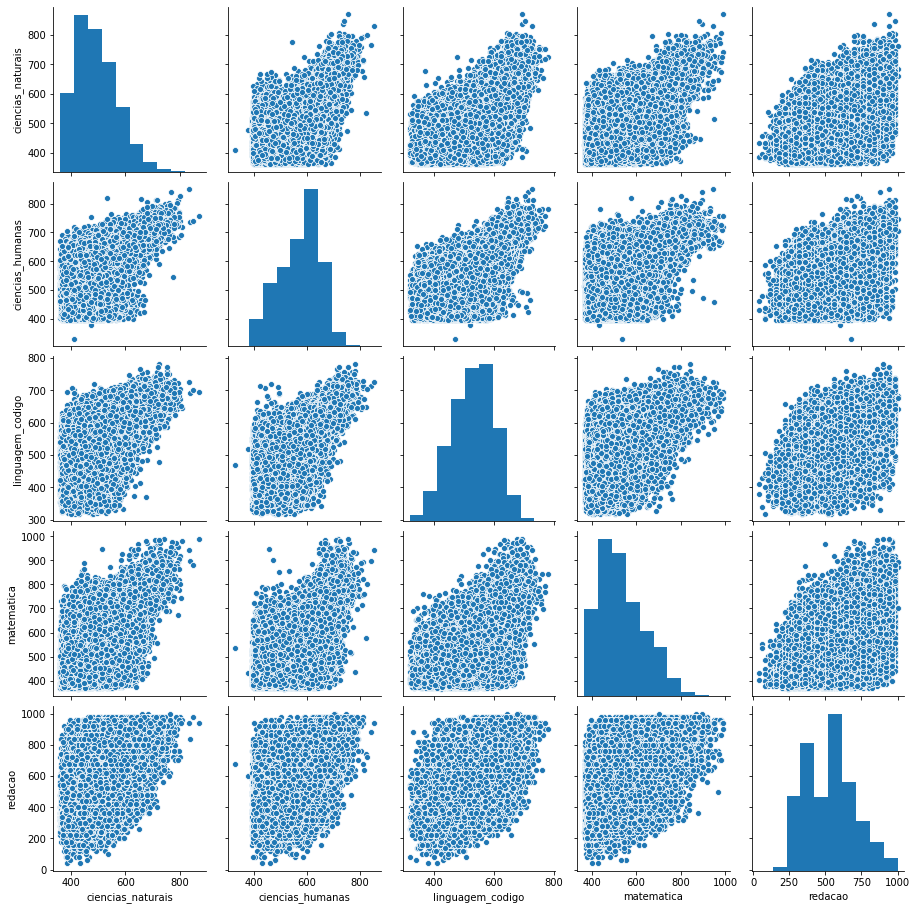

In [21]:
sns.pairplot(dados_sem_zero)
dados_sem_zero.head()

## Desafio 5
Quais questões tiveram mais erros (análise sobre o gabarito x acertos x erros)

In [0]:
def correcao(prova, gabarito, respostas):
  new_cols = list(range(prova[respostas].map(len).max()))
  prova = prova.reindex(columns=[*prova.columns.tolist(),*new_cols], fill_value=0)
  for i, row in prova.iterrows():
    for j, (g, h) in enumerate(zip(row[respostas], row[gabarito])):
      if g == h:
        prova.at[i,j] = 1
  return prova, new_cols

In [24]:
matematica = dados[['TX_GABARITO_MT', 'CO_PROVA_MT', 'TX_RESPOSTAS_MT']].dropna()
matematica, rn = correcao(matematica, 'TX_GABARITO_MT', 'TX_RESPOSTAS_MT')
matematica.groupby("CO_PROVA_MT")[[*rn]].apply(lambda x: x[x == 0].count()/x.count())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
CO_PROVA_MT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
459.00,0.76,0.76,0.82,0.83,0.66,0.75,0.75,0.75,0.65,0.75,0.67,0.67,0.74,0.68,0.64,0.70,0.81,0.73,0.82,0.78,0.83,0.83,0.79,0.26,0.68,0.89,0.73,1.00,0.65,0.74,0.78,0.79,0.63,0.75,0.81,0.76,0.55,0.79,0.72,0.70,0.80,0.68,0.82,0.80,0.79
460.00,0.66,0.66,0.74,0.78,0.84,0.83,0.79,0.58,0.74,0.82,0.23,0.67,0.90,0.71,1.00,0.76,0.75,0.66,0.74,0.74,0.51,0.84,0.67,0.76,0.65,0.73,0.78,0.79,0.79,0.78,0.82,0.66,0.82,0.79,0.77,0.72,0.69,0.80,0.79,0.70,0.69,0.72,0.79,0.76,0.82
461.00,0.76,0.74,0.63,0.74,0.70,0.47,0.62,0.72,0.78,0.78,0.79,0.77,0.82,0.83,0.68,0.76,0.60,0.75,0.80,0.79,0.65,0.71,0.81,0.72,0.69,0.79,0.70,0.69,0.75,0.78,0.84,0.83,0.78,0.29,0.77,0.82,0.72,0.67,0.82,0.80,0.78,0.71,0.88,0.76,1.00
462.00,0.84,0.65,0.74,0.78,0.77,0.81,0.62,0.83,0.76,0.78,0.63,0.70,0.81,0.72,0.69,0.79,0.25,0.73,0.82,0.70,0.64,0.74,0.78,0.79,0.77,0.76,0.66,0.75,0.79,0.75,0.54,0.69,0.87,0.76,1.00,0.64,0.75,0.80,0.79,0.83,0.83,0.78,0.72,0.72,0.76
466.00,0.71,0.71,0.86,0.57,0.71,0.71,1.00,0.71,0.71,0.86,0.43,0.71,0.86,0.57,1.00,1.00,0.86,0.86,0.86,1.00,0.57,0.86,0.71,0.57,0.86,0.57,0.71,0.71,0.86,0.57,0.86,0.71,0.71,1.00,0.86,1.00,0.71,0.71,0.86,0.86,0.71,0.86,0.86,1.00,0.86
470.00,0.86,0.85,0.80,0.69,0.86,0.88,0.92,0.78,0.69,0.88,0.37,0.66,0.78,0.88,1.00,0.78,0.88,0.80,0.80,0.80,0.76,0.88,0.75,0.73,0.92,0.78,0.78,0.80,0.85,0.83,0.86,0.75,0.90,0.90,0.83,0.71,0.75,0.80,0.68,0.69,0.68,0.78,0.81,0.83,0.76


In [26]:
linguagens = dados[['TX_GABARITO_LC', 'CO_PROVA_LC', 'TX_RESPOSTAS_LC']].dropna()
linguagens, rn = correcao(linguagens, 'TX_GABARITO_LC', 'TX_RESPOSTAS_LC')
linguagens.groupby("CO_PROVA_LC")[[*rn]].apply(lambda x: x[x == 0].count()/x.count())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
CO_PROVA_LC,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
455.00,0.74,0.68,0.77,0.82,0.72,0.79,0.84,0.77,0.78,0.74,0.52,0.63,0.60,0.49,0.64,0.46,0.64,0.45,0.89,0.78,0.67,0.72,0.54,0.47,0.72,0.82,0.40,0.60,0.66,0.44,0.72,0.52,0.44,0.84,0.68,0.52,0.56,0.76,0.75,0.79,0.51,0.75,0.79,0.53,0.68,0.75,0.73,0.70,0.70,0.58
456.00,0.67,0.75,0.83,0.77,0.71,0.75,0.72,0.80,0.78,0.85,0.80,0.37,0.57,0.63,0.43,0.71,0.47,0.43,0.85,0.68,0.48,0.55,0.75,0.67,0.70,0.55,0.48,0.88,0.78,0.74,0.77,0.51,0.67,0.72,0.71,0.75,0.78,0.53,0.70,0.51,0.64,0.47,0.73,0.70,0.74,0.61,0.59,0.68,0.62,0.60
457.00,0.68,0.67,0.82,0.77,0.75,0.80,0.73,0.78,0.78,0.85,0.71,0.47,0.42,0.45,0.72,0.81,0.39,0.59,0.74,0.77,0.50,0.67,0.74,0.68,0.68,0.48,0.65,0.66,0.43,0.68,0.72,0.58,0.75,0.80,0.50,0.58,0.67,0.62,0.56,0.50,0.88,0.77,0.70,0.70,0.58,0.60,0.75,0.85,0.71,0.54
458.00,0.75,0.68,0.77,0.83,0.67,0.76,0.84,0.76,0.80,0.73,0.62,0.71,0.49,0.73,0.79,0.48,0.66,0.73,0.70,0.75,0.76,0.47,0.67,0.42,0.80,0.41,0.60,0.55,0.66,0.61,0.54,0.46,0.72,0.58,0.75,0.69,0.47,0.63,0.68,0.70,0.56,0.85,0.70,0.53,0.73,0.53,0.42,0.52,0.88,0.77
465.00,1.00,1.00,0.88,1.00,0.88,0.50,0.62,0.38,0.75,0.62,0.50,0.88,0.62,0.62,0.50,0.62,0.38,0.25,0.62,0.88,0.62,1.00,0.50,0.50,1.00,0.75,1.00,0.50,0.62,0.38,0.75,0.75,0.25,1.00,0.75,0.62,0.62,0.88,1.00,0.50,0.75,0.88,0.88,0.75,0.62,0.88,0.75,1.00,0.88,0.75
469.00,0.97,0.93,0.91,0.95,0.95,0.83,0.76,0.88,0.88,0.71,0.86,0.83,0.71,0.66,0.74,0.81,0.66,0.79,0.79,0.74,0.69,0.79,0.69,0.76,0.72,0.84,0.67,0.79,0.83,0.64,0.69,0.88,0.81,0.86,0.78,0.88,0.84,0.90,0.84,0.90,0.60,0.83,0.84,0.78,0.78,0.76,0.84,0.78,0.72,0.84
495.00,0.33,0.33,0.67,0.50,0.67,0.83,0.83,1.00,1.00,1.00,0.50,0.50,0.33,0.50,0.50,0.50,0.00,0.67,0.83,0.83,0.50,0.67,0.83,0.67,0.50,0.50,0.67,0.17,0.33,0.50,0.33,0.83,0.67,0.50,0.83,0.67,0.67,0.50,0.67,0.83,0.33,0.33,0.50,0.50,0.33,0.67,0.17,0.33,0.17,0.50
496.00,0.60,1.00,0.60,1.00,0.80,0.40,0.60,1.00,0.80,0.80,0.80,0.20,0.20,0.40,0.60,0.40,0.60,0.20,0.60,0.60,0.40,0.20,0.60,0.20,0.80,0.40,0.60,0.80,0.60,0.60,0.80,0.80,1.00,0.40,0.60,0.60,0.20,0.80,0.60,0.40,0.80,1.00,0.60,0.40,0.80,0.40,0.80,1.00,0.40,0.60
497.00,0.50,0.67,0.67,0.50,0.83,0.83,0.50,0.67,0.83,0.83,0.67,0.50,0.67,0.33,0.50,0.17,0.50,0.50,0.17,0.50,0.50,0.50,0.33,0.83,0.67,0.50,0.67,0.83,0.83,0.50,1.00,0.83,0.83,0.33,0.50,0.50,0.67,0.50,0.50,0.67,0.50,0.50,0.50,0.50,0.17,0.67,0.83,0.50,0.50,0.67


In [27]:
humanas = dados[['TX_GABARITO_CH', 'CO_PROVA_CH', 'TX_RESPOSTAS_CH']].dropna()
humanas, rn = correcao(humanas, 'TX_GABARITO_CH', 'TX_RESPOSTAS_CH')
humanas.groupby("CO_PROVA_CH")[[*rn]].apply(lambda x: x[x == 0].count()/x.count())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
CO_PROVA_CH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
451.00,0.75,0.75,0.60,0.70,0.67,0.49,0.68,0.85,0.46,0.59,0.66,0.50,0.73,0.53,0.39,0.60,0.58,0.67,0.54,0.70,0.76,0.72,0.59,0.78,0.69,0.68,0.75,0.61,0.47,0.86,0.48,0.79,0.65,0.76,0.58,0.82,0.71,0.76,0.50,0.48,0.64,0.44,0.64,0.73,0.69
452.00,0.70,0.76,0.70,0.56,0.78,0.63,0.75,0.55,0.80,0.69,0.76,0.74,0.76,0.62,0.71,0.52,0.73,0.55,0.43,0.67,0.52,0.69,0.86,0.60,0.60,0.67,0.57,0.65,0.73,0.71,0.49,0.47,0.63,0.42,0.63,0.46,0.85,0.49,0.79,0.70,0.70,0.76,0.56,0.63,0.68
453.00,0.43,0.57,0.66,0.79,0.69,0.64,0.76,0.55,0.43,0.87,0.42,0.69,0.49,0.68,0.86,0.70,0.76,0.71,0.58,0.78,0.63,0.76,0.57,0.81,0.77,0.76,0.65,0.72,0.55,0.72,0.56,0.47,0.64,0.73,0.72,0.50,0.47,0.63,0.43,0.71,0.76,0.62,0.62,0.67,0.57
454.00,0.65,0.74,0.67,0.43,0.38,0.61,0.38,0.69,0.75,0.79,0.63,0.75,0.55,0.81,0.58,0.45,0.86,0.45,0.79,0.69,0.66,0.76,0.53,0.72,0.56,0.46,0.63,0.60,0.66,0.57,0.68,0.78,0.74,0.61,0.55,0.64,0.68,0.69,0.55,0.71,0.85,0.78,0.77,0.67,0.72
464.00,0.88,0.62,0.50,0.88,0.75,0.25,0.75,0.88,0.62,0.75,0.62,0.38,0.75,0.38,0.25,0.62,0.75,0.62,0.62,0.88,0.88,0.75,0.50,0.75,0.75,0.75,0.75,0.62,0.62,1.00,0.38,0.88,0.38,0.88,0.75,1.00,0.62,0.88,0.38,0.50,0.50,0.62,0.75,0.62,0.62
468.00,0.91,0.69,0.72,0.83,0.83,0.79,0.84,0.74,0.64,0.76,0.76,0.76,0.83,0.79,0.71,0.74,0.79,0.60,0.67,0.67,0.79,0.86,0.76,0.76,0.71,0.81,0.93,0.74,0.86,0.79,0.78,0.69,0.72,0.81,0.76,0.81,0.79,0.72,0.71,0.60,0.71,0.74,0.72,0.79,0.86
491.00,0.00,0.33,0.17,0.67,0.83,0.33,0.33,0.67,0.17,0.17,0.50,0.17,0.67,0.00,0.17,1.00,0.17,0.33,0.83,0.50,0.67,0.17,0.33,0.50,1.00,0.83,0.67,0.33,0.33,0.33,0.83,0.17,0.67,0.17,0.67,0.33,0.50,0.83,0.17,0.67,0.67,0.33,0.33,0.17,0.50
492.00,0.40,0.40,0.80,0.40,0.00,0.20,0.80,0.80,0.20,0.40,0.00,0.80,0.80,0.60,0.60,0.40,0.00,0.60,0.60,0.60,1.00,0.20,0.60,0.20,0.20,0.40,0.20,0.40,0.80,0.40,0.80,1.00,0.20,0.40,0.00,0.20,0.60,0.60,0.20,0.20,0.60,0.80,0.00,0.00,0.20
493.00,0.67,0.50,0.67,0.67,0.33,0.83,0.67,0.17,0.83,0.50,0.83,0.17,0.33,0.50,0.67,0.17,0.00,0.50,1.00,0.67,0.67,0.83,0.50,0.33,0.50,0.83,0.50,0.33,0.50,0.17,0.50,0.67,0.17,0.83,0.50,0.33,0.67,0.17,0.50,0.00,0.33,0.67,0.17,1.00,0.50


In [25]:
natureza = dados[['TX_GABARITO_CN', 'CO_PROVA_CN', 'TX_RESPOSTAS_CN']].dropna()
natureza, rn = correcao(natureza, 'TX_GABARITO_CN', 'TX_RESPOSTAS_CN')
natureza.groupby("CO_PROVA_CN")[[*rn]].apply(lambda x: x[x == 0].count()/x.count())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
CO_PROVA_CN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
447.00,0.77,0.78,0.63,0.74,0.76,0.76,0.52,0.70,0.74,0.50,0.84,0.85,0.77,0.87,0.74,0.76,0.76,0.76,0.65,0.84,0.74,0.80,0.50,0.81,0.59,0.88,0.60,0.71,0.70,0.83,0.71,0.74,0.85,0.78,0.72,0.59,0.70,0.76,0.72,0.84,0.69,0.72,0.77,0.88,0.83
448.00,0.77,0.50,0.73,0.76,0.50,0.69,0.85,0.66,0.77,0.78,0.74,0.76,0.89,0.84,0.74,0.80,0.48,0.81,0.58,0.77,0.65,0.84,0.88,0.59,0.84,0.84,0.76,0.87,0.74,0.76,0.76,0.70,0.71,0.83,0.65,0.74,0.78,0.72,0.61,0.71,0.76,0.73,0.75,0.84,0.78
449.00,0.69,0.84,0.66,0.68,0.75,0.76,0.76,0.90,0.84,0.64,0.73,0.76,0.76,0.76,0.85,0.85,0.78,0.88,0.73,0.88,0.59,0.77,0.67,0.84,0.74,0.80,0.50,0.80,0.60,0.72,0.71,0.84,0.72,0.60,0.71,0.74,0.84,0.78,0.77,0.77,0.75,0.56,0.74,0.74,0.55
450.00,0.75,0.77,0.90,0.84,0.64,0.74,0.84,0.78,0.67,0.77,0.74,0.79,0.49,0.81,0.58,0.70,0.56,0.89,0.58,0.71,0.70,0.83,0.64,0.72,0.77,0.76,0.76,0.77,0.67,0.85,0.84,0.85,0.77,0.87,0.74,0.75,0.55,0.74,0.75,0.56,0.77,0.78,0.73,0.84,0.69
463.00,0.86,0.43,0.71,0.57,0.43,0.86,1.00,0.71,0.57,0.71,0.86,1.00,0.71,0.86,0.86,1.00,0.43,0.71,0.86,0.71,0.86,1.00,0.43,0.71,0.86,0.86,0.57,1.00,0.86,0.57,0.57,0.86,0.86,0.86,1.00,0.57,0.71,0.86,0.71,0.71,0.86,1.00,0.57,0.86,1.00
467.00,0.75,0.76,0.78,0.93,0.80,0.81,0.83,0.83,0.56,0.88,0.75,0.86,0.90,0.90,0.80,0.73,0.75,0.75,0.66,0.86,0.64,0.90,0.90,0.76,0.83,0.81,0.83,0.86,0.81,0.88,0.80,0.86,0.66,0.81,0.81,0.81,0.90,0.80,0.56,0.86,0.75,0.90,0.78,0.90,0.88


In [0]:
def corrige_questoes(aluno, materia):
    respostas = aluno.get(f'TX_RESPOSTAS_{materia}')
    gabarito = aluno.get(f'TX_GABARITO_{materia}')
    
    return pd.Series([int(a==b) for a, b in zip(respostas, gabarito)])

Analisando a prova de uma cor e matéria especifica.

In [0]:
cor = 'azul'
nome_materia = 'Ciências da Natureza'
materia = 'CN'
cod_cor = '447'

Usando essas variaveis pode-se gerar o grafico da matéria e cor especica no qual deseja-se analisar.

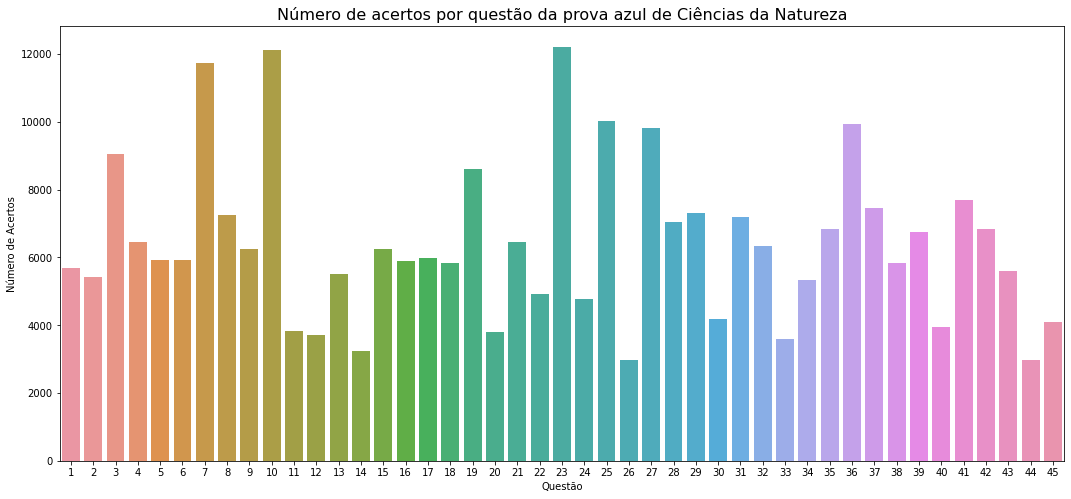

In [43]:
prova_cor = dados.query(f'CO_PROVA_{materia} == {cod_cor}')
matriz_acertos = prova_cor.apply(corrige_questoes, materia=materia, axis=1)


total_acertos_por_questao = pd.DataFrame(matriz_acertos.sum())
total_acertos_por_questao.reset_index(inplace=True)
total_acertos_por_questao.columns = ['Questão', 'Número de Acertos']
total_acertos_por_questao['Questão'] = total_acertos_por_questao['Questão'] + 1
plt.figure(figsize=(18, 8))
ax = sns.barplot(x='Questão', y='Número de Acertos', data=total_acertos_por_questao)
ax.set_title(f'Número de acertos por questão da prova {cor} de {nome_materia}', fontsize=16)
plt.show()

## Desafio 6
Estudar o que as pessoas que estudam o assunto estão discutindo e conclusões que já chegaram sobre a utilização de informações (principalmente sensíveis) para machine learning e data science. Podcast do datahackers também sobre o assunto.